# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 본인의 구글 드라이브에 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Tensorflow Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Data Argumentation & Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Data Augmentation을 적용하세요.(Image Generator)
            * Transfer Learning(VGG16)


## 1.환경설정 

### (1) 데이터셋 폴더 생성
- **세부요구사항**
    - C드라이브에 Datasets라는 폴더를 만드세요.
        - 구글드라이브를 사용하는경우 드라이브 첫 화면에 Datasets 라는 폴더를 만드세요. ('/content/drive/MyDrive/Datasets/')
    - 해당 폴더 안에 Car_Images.zip 파일을 넣으세요.

* 구글 Colab을 이용하는 경우

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 데이터셋 불러오기 
- **세부요구사항**
    - Car_Images.zip 파일을 C:/Datasets/ 경로에 압축 해제합니다.
    - zipfile 모듈을 이용하거나 다른 방식을 사용해도 됩니다.
        - 참고 자료 : [zipfile document](https://docs.python.org/3/library/zipfile.html#zipfile-objects)
    - 폴더구조(로컬)
        * C:/Datasets/ : 압축파일
        * C:/Datasets/Car_Images_train/ : 압축 해제한 이미지 저장소
    - 폴더구조(구글드라이브브)
        * /content/drive/MyDrive/Datasets/ : 압축파일
        * /content/drive/MyDrive/Datasets/Car_Images_train/ : 압축 해제한 이미지 저장소
    - 압축을 해제하면 다음과 같은 두 하위 폴더가 생성됩니다.
        * normal, abnormal : 각 폴더에는 이미지들이 있습니다.
        * 이후 단계에서 해당 경로로 부터 validation, test 셋을 추출하게 됩니다.
        

In [2]:
import zipfile

In [5]:
# 압축파일 경로
# 구글 드라이브인 경우 경로에 맞게 지정하세요.
dataset_path  = '/content/drive/MyDrive/Datasets/'
# dataset_path = 'C:/Datasets/'

file_path = dataset_path + 'Car_Images.zip'

In [4]:
# 압축 해제
data = zipfile.ZipFile(file_path)
data.extractall("/content/drive/MyDrive/Datasets/Car_Images_train")

KeyboardInterrupt: ignored

### (3) 이미지 저장을 위한 폴더 생성
- **세부요구사항**
    - train, validation, test 을 위해 각각 하위 폴더 normal과 abnormal를 준비합니다.
        - train
            * 정상 이미지 저장소 : C:/Datasets/Car_Images_train/normal/ 
                * 구글드라이브 :   /content/drive/MyDrive/Datasets/Car_Images_train/normal/
            * 파손 이미지 저장소 : C:/Datasets/Car_Images_train/abnormal/
                * 구글드라이브 : /content/drive/MyDrive/Datasets/Car_Images_train/abnormal/
        - val, test 역시 동일한 구조로 생성합니다.
    - 직접 탐색기에서 폴더를 생성할 수도 있고, os 모듈을 이용하여 코드로 작성할 수도 있습니다.
        - 참고 자료 : [os document](https://docs.python.org/3/library/os.html)

In [5]:
import os
# 각각 경로 지정
tr_n_path = "/content/drive/MyDrive/Datasets/Car_Images_train/normal"
tr_ab_path = "/content/drive/MyDrive/Datasets/Car_Images_train/abnormal"

# test 폴더 만들기 os.mkdir()
os.mkdir("/content/drive/MyDrive/Datasets/Car_Images_train/test")


# validation 폴더 만들기
os.mkdir("/content/drive/MyDrive/Datasets/Car_Images_train/val")

FileExistsError: ignored

## 2.데이터 전처리

### (1) 데이터 분할 : Training set | Validation set | Test set 생성
- **세부요구사항**
    - Training set, Validation set, Test set을 만듭니다.
        * size
            * test : 전체에서 20%를 추출합니다.
            * validation : test를 떼어낸 나머지에서 다시 20%를 추출합니다.
        * 데이터는 랜덤하게 추출해야 합니다.
            - random, shutil 모듈을 이용하여 랜덤하게 추출할 수 있습니다.
                - [random document](https://docs.python.org/3/library/random.html) | [shutil document](https://docs.python.org/3/library/shutil.html)
            * 해당 모듈 이외에 자신이 잘 알고 있는 방법을 사용해도 됩니다.
---

#### 1) test, validation 크기를 지정

In [6]:
import random, shutil

In [7]:
# 전체 이미지 갯수를 확인합니다.
len(os.listdir(tr_n_path)) , len(os.listdir(tr_ab_path))

(302, 303)

In [8]:
# test 사이즈 : 전체 이미지의 20%
te_data_num = [round(len(os.listdir(tr_n_path))*0.2), round(len(os.listdir(tr_ab_path))*0.2)]
print(te_data_num)

# validation 사이즈 : test를 제외한 나머지 중에서 20%
val_data_num = [ round((len(os.listdir(tr_n_path))-te_data_num[0])*0.2) , round((len(os.listdir(tr_n_path))-te_data_num[1])*0.2) ]
print(val_data_num)

# train 사이즈
train_data_num = [len(os.listdir(tr_n_path)) - te_data_num[0] - val_data_num[0],
                  len(os.listdir(tr_ab_path))- te_data_num[1] - val_data_num[1]]

[60, 61]
[48, 48]


#### 2) train set, test set, val set, 추출

In [9]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import splitfolders
data = "/content/drive/MyDrive/Datasets/Car_Images_train/"
splitfolders.ratio(data, output = "/content/drive/MyDrive/Datasets/Car_Images_train", seed = 2023, ratio = (0.8, 0.1, 0.1))


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  8.35 files/s]
Copying files: 5 files [00:00, 10.10 files/s]
Copying files: 10 files [00:00, 18.68 files/s]
Copying files: 14 files [00:00, 22.30 files/s]
Copying files: 17 files [00:00, 23.80 files/s]
Copying files: 21 files [00:00, 27.10 files/s]
Copying files: 26 files [00:01, 31.32 files/s]
Copying files: 30 files [00:01, 31.90 files/s]
Copying files: 34 files [00:01, 31.47 files/s]
Copying files: 39 files [00:01, 35.67 files/s]
Copying files: 44 files [00:01, 39.00 files/s]
Copying files: 49 files [00:01, 36.55 files/s]
Copying files: 54 files [00:01, 39.10 files/s]
Copying files: 59 files [00:01, 39.86 files/s]
Copying files: 64 files [00:02, 38.86 files/s]
Copying files: 68 files [00:02, 37.17 files/s]
Copying files: 73 files [00:02, 38.64 files/s]
Copying files: 77 files [00:02, 24.93 files/s]
Copying files: 81 files [00:02, 23.60 files/s]
Copying files: 84 files [00:03, 20.59 files/s]
Copying files: 87 f

In [10]:
!rmdir "/content/drive/MyDrive/Datasets/Car_Images_train/test/test"
!rmdir "/content/drive/MyDrive/Datasets/Car_Images_train/test/val"

!rmdir "/content/drive/MyDrive/Datasets/Car_Images_train/train/test"
!rmdir "/content/drive/MyDrive/Datasets/Car_Images_train/train/val"

!rmdir "/content/drive/MyDrive/Datasets/Car_Images_train/val/test"
!rmdir "/content/drive/MyDrive/Datasets/Car_Images_train/val/val"

rmdir: failed to remove '/content/drive/MyDrive/Datasets/Car_Images_train/test/test': No such file or directory
rmdir: failed to remove '/content/drive/MyDrive/Datasets/Car_Images_train/test/val': No such file or directory
rmdir: failed to remove '/content/drive/MyDrive/Datasets/Car_Images_train/train/test': No such file or directory
rmdir: failed to remove '/content/drive/MyDrive/Datasets/Car_Images_train/train/val': No such file or directory
rmdir: failed to remove '/content/drive/MyDrive/Datasets/Car_Images_train/val/test': No such file or directory
rmdir: failed to remove '/content/drive/MyDrive/Datasets/Car_Images_train/val/val': No such file or directory


In [11]:
# 전체 이미지 갯수를 확인합니다.
len(os.listdir(tr_n_path)) , len(os.listdir(tr_ab_path))

(302, 303)

In [12]:
# 추출 후 이미지 갯수 확인
train_n_path = "/content/drive/MyDrive/Datasets/Car_Images_train/train/normal"
train_ab_path = "/content/drive/MyDrive/Datasets/Car_Images_train/train/abnormal"

test_n_path = "/content/drive/MyDrive/Datasets/Car_Images_train/test/normal"
test_ab_path = "/content/drive/MyDrive/Datasets/Car_Images_train/test/abnormal"

val_n_path = "/content/drive/MyDrive/Datasets/Car_Images_train/val/normal"
val_ab_path = "/content/drive/MyDrive/Datasets/Car_Images_train/val/abnormal"

# 전체 이미지 갯수를 확인합니다.
print("train : ", len(os.listdir(train_n_path)) , len(os.listdir(train_ab_path)))
print("test : ", len(os.listdir(test_n_path)) , len(os.listdir(test_ab_path)))
print("val : ", len(os.listdir(val_n_path)) , len(os.listdir(val_ab_path)))

train :  241 242
test :  31 31
val :  30 30


### (2) 데이터 복사 및 이동
- **세부요구사항**
    - 분할된 데이터를 복사 이동합니다.
        - 새로운 폴더에 저장하는 데이터로 "3.모델링I"에서 사용합니다.
        - 기존 폴더는 "4.모델링II > (1) Data Augmentation"에서 사용합니다.
    - Training set | Validation set | Test set의 데이터를 **새로운 폴더**에 복사하세요.
        - 새로운 폴더 명
            * copy_images/trainset
            * copy_images/validset
            * copy_images/testset
        - 새로운 폴더에는 normal, abnormal 파일 모두를 복사합니다. 
            * 파일을 구분하기 위해 abnormal 파일들은 파일명 앞에 접두사 'ab_'를 붙입시다.
        - os, shutil 모듈을 활용하세요.

#### 1) abnormal 파일 복사

* 복사하기 : shutil.copytree()

In [3]:
import os
import shutil
from pathlib import Path

In [14]:
# 기존 폴더 경로
base_path = '/content/drive/MyDrive/Datasets/Car_Images_train/'
train_normal_path = base_path + 'train/normal/'
train_abnormal_path = base_path + 'train/abnormal/'
val_normal_path = base_path + 'val/normal/'
val_abnormal_path = base_path + 'val/abnormal/'
test_normal_path = base_path + 'test/normal/'
test_abnormal_path = base_path + 'test/abnormal/'

# 새로운 폴더 경로
new_base_path = '/content/drive/MyDrive/Datasets/copy_images/'
new_train_path = new_base_path + 'trainset/'
new_val_path = new_base_path + 'validset/'
new_test_path = new_base_path + 'testset/'

# 새로운 폴더 생성
Path(new_train_path).mkdir(parents = True, exist_ok = True)
Path(new_val_path).mkdir(parents = True, exist_ok = True)
Path(new_test_path).mkdir(parents = True, exist_ok = True)

# 복사 함수 정의
def copy_files(src_path, dest_path, prefix = ''):
    for file_name in os.listdir(src_path):
        shutil.copy(src_path + file_name, dest_path + prefix + file_name)

# normal, abnormal 파일 복사
copy_files(train_normal_path, new_train_path)
copy_files(train_abnormal_path, new_train_path, prefix = 'ab_')

copy_files(val_normal_path, new_val_path)
copy_files(val_abnormal_path, new_val_path, prefix = 'ab_')

copy_files(test_normal_path, new_test_path)
copy_files(test_abnormal_path, new_test_path, prefix = 'ab_')

* 데이터 갯수 조회

In [6]:
print(len(os.listdir(dataset_path + 'copy_images/trainset/')))
print(len(os.listdir(dataset_path + 'copy_images/validset/')))
print(len(os.listdir(dataset_path + 'copy_images/testset/')))

483
60
62


## 3.모델링 I
* **세부요구사항**
    * 모델링을 위한 데이터 구조 만들기
        * x : 이미지를 array로 변환합니다.
        * y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### (1) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다. 
    * 이미지 파일을 불러와 train, valid, test 각각 array 형태로 변환해 봅시다.
        * 각 폴더로 부터 이미지 목록을 만들고
        * 이미지 한장씩 적절한 크기로 로딩하여 (keras.utils.load_img)
            * 이미지가 너무 크면 학습시간이 많이 걸리고, 메모리 부족현상이 발생될 수 있습니다.
            * 이미지 크기를 280 * 280 * 3 이내의 크기를 설정하여 로딩하시오.
            * array로 변환 (keras.utils.img_to_array, np.expand_dims)
        * 데이터셋에 추가합니다.(데이터셋도 array)

#### 1) 이미지 목록 만들기
* train, validation, test 폴더로 부터 이미지 목록을 생성합니다.

#### 2) 이미지들을 배열 데이터셋으로 만들기

In [5]:
import os

# 이미지 경로 설정
dataset_path  = '/content/drive/MyDrive/Datasets/'
img_train_path = dataset_path + 'copy_images/trainset/'
img_valid_path = dataset_path + 'copy_images/validset/'
img_test_path = dataset_path + 'copy_images/testset/'

# 각 폴더에서 이미지 목록 가져오기
img_train_list = os.listdir(img_train_path)
img_valid_list = os.listdir(img_valid_path)
img_test_list = os.listdir(img_test_path)

# 이미지 크기 설정
# img_size = 280
img_size = 224

# 데이터셋 생성
def create_dataset(image_list, image_path):
    dataset = []
    for img_name in image_list:
        # 이미지 크기를 조절하며 로드
        img = load_img(image_path + img_name, target_size = (img_size, img_size))

        # 이미지를 배열로 변환
        img_array = img_to_array(img)

        # 이미지 배열의 차원을 확장
        img_array = np.expand_dims(img_array, axis=0)

        # 데이터셋에 추가
        dataset.append(img_array)

    # 배열들을 하나의 배열로 합치기
    dataset = np.vstack(dataset)
    return dataset

# 각 폴더의 이미지들을 배열 데이터셋으로 변환
x_train = create_dataset(img_train_list, img_train_path)
x_valid = create_dataset(img_valid_list, img_valid_path)
x_test = create_dataset(img_test_list, img_test_path)

In [87]:
x_train_s = x_train.copy()
x_test_s = x_test.copy()
x_valid_s = x_valid.copy()

In [88]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

# 이미지 데이터 스케일링
x_train_s = preprocess_input(x_train_s)
x_test_s = preprocess_input(x_test_s)
x_valid_s = preprocess_input(x_valid_s)

In [89]:
print((x_train_s.max(), x_train_s.min()))
x_train_s.shape, x_valid_s.shape, x_test_s.shape

(1.0, -1.0)


((483, 224, 224, 3), (60, 224, 224, 3), (62, 224, 224, 3))

### (2) y : 클래스 만들기
- **세부요구사항**
    - Training set / Validation set / Test set의 y를 생성합니다.
        - 각각 normal, abnormal 데이터의 갯수를 다시 확인하고
        - normal을 0, abnormal을 1로 지정합니다.

In [8]:
# 데이터 갯수 확인
print(len(img_train_list))  # 전체 학습 데이터 갯수 출력
print(len([val for val in img_train_list if val.startswith('ab_')]))  # abnormal 학습 데이터 갯수 출력
print('---')

print(len(img_valid_list) )
print(len([val for val in img_valid_list if val.startswith('ab_')]))
print('---')

print(len(img_test_list) )
print(len([val for val in img_test_list if val.startswith('ab_')]))

483
242
---
60
30
---
62
31


* y_train, y_valid, y_test 만들기
    * normal, abnormal 데이터의 갯수를 다시 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [90]:
def create_labels(image_list):
    labels = []
    for img_name in image_list:
        if img_name.startswith('ab_'):
            labels.append(1)  # abnormal
        else:
            labels.append(0)  # normal
    return np.array(labels)

y_train = create_labels(img_train_list)
y_valid = create_labels(img_valid_list)
y_test = create_labels(img_test_list)

In [10]:
y_train.shape, y_valid.shape, y_test.shape

((483,), (60,), (62,))

### (3) 모델1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

#### 1) 구조 설계

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

keras.backend.clear_session()

base_model = InceptionV3(weights = 'imagenet',       
                         include_top = False,        
                         input_shape = (224,224,3))

new_output = GlobalAveragePooling2D()(base_model.output)
new_output = Dense(1, activation = 'sigmoid')(new_output)

model = keras.models.Model(base_model.inputs, new_output)

model.compile(loss='binary_crossentropy', metrics=['accuracy'],
             optimizer = keras.optimizers.Adam(learning_rate = 0.001))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

#### 2) 학습
* EarlyStopping 설정하고 학습시키기

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss',
                                 patience = 4,
                                 verbose = 1,
                                 factor = 0.2,
                                 min_lr = 0.0001)

es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 8,
                   verbose = 1, 
                   restore_best_weights = True)

#### 3) test set으로 예측하고 평가하기
* 평가는 confusion_matrix, classification_report 활용

In [38]:
history = model.fit(x_train_s, y_train, epochs = 100, verbose = 1,
                    validation_data = (x_valid_s, y_valid), callbacks = [es, lr_reduction], batch_size = 16)

Epoch 1/100
31/31 [==============================] - 41s 273ms/step - loss: 0.4858 - accuracy: 0.8116 - val_loss: 122.8606 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 4s 136ms/step - loss: 0.2915 - accuracy: 0.8882 - val_loss: 12.1418 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 4s 131ms/step - loss: 0.1824 - accuracy: 0.9379 - val_loss: 85.3390 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - 4s 137ms/step - loss: 0.1297 - accuracy: 0.9441 - val_loss: 4.8803 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 5/100
31/31 [==============================] - 4s 138ms/step - loss: 0.0850 - accuracy: 0.9731 - val_loss: 0.7263 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 6/100
31/31 [==============================] - 4s 133ms/step - loss: 0.0771 - accuracy: 0.9731 - val_loss: 3.0851 - val_accuracy: 0.6167 - lr: 0.0010
Epoch 7/100
31/31 [==============================] - 4s 134

In [39]:
#EarlyStopping, ReduceLROnPlateau 둘 다 적용
from sklearn.metrics import classification_report
y_pred = model.predict(x_test_s)
y_pred = np.ravel(np.round(y_pred)).astype(int)
print(classification_report(y_test, y_pred))

2/2 [==============================] - 4s 1s/step
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        31
           1       0.97      0.90      0.93        31

    accuracy                           0.94        62
   macro avg       0.94      0.94      0.94        62
weighted avg       0.94      0.94      0.94        62



In [370]:
#EarlyStopping만 적용
from sklearn.metrics import classification_report
y_pred = model.predict(x_test_s)
y_pred = np.ravel(np.round(y_pred)).astype(int)
print(classification_report(y_test, y_pred))

2/2 [==============================] - 0s 139ms/step
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        31
           1       0.93      0.90      0.92        31

    accuracy                           0.92        62
   macro avg       0.92      0.92      0.92        62
weighted avg       0.92      0.92      0.92        62



In [40]:
#EarlyStopping, ReduceLROnPlateau 둘 다 적용
performance_test = model.evaluate(x_test_s, y_test, batch_size = 16)
print(f'Test Loss : {performance_test[0]:.6f} |  Test Accuracy : {performance_test[1]*100:.2f}%')

4/4 [==============================] - 1s 346ms/step - loss: 0.1387 - accuracy: 0.9355
Test Loss : 0.138681 |  Test Accuracy : 93.55%


In [277]:
#EarlyStopping만 적용
performance_test = model.evaluate(x_test_s, y_test, batch_size = 16)
print(f'Test Loss : {performance_test[0]:.6f} |  Test Accuracy : {performance_test[1]*100:.2f}%')

4/4 [==============================] - 0s 78ms/step - loss: 0.2070 - accuracy: 0.9194
Test Loss : 0.206959 |  Test Accuracy : 91.94%


ID : 61
다음 그림은 1 입니다.
모델의 예측 : [1.]
정답입니다


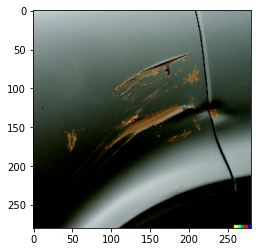

In [310]:
import random as rd
id = rd.randrange(0,62)

print("ID :", id)
print(f'다음 그림은 {y_test[id]} 입니다.')
print(f'모델의 예측 : {y_pred[id]}')

if y_test[id] == y_pred[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
    
plt.imshow(x_test_s[id].reshape(280, 280, 3))
plt.show()

In [ ]:
58, 34, 31, 27, 21

ID : 34
다음 그림은 1 입니다.
모델의 예측 : 0
틀렸어요


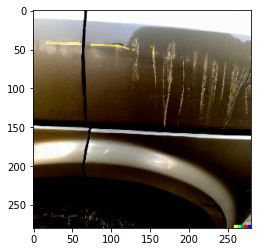

In [367]:
true_false = (y_test == y_pred)
f_id = np.where(true_false == False)[0]
f_n = len(f_id)

id = f_id[rd.randrange(0,f_n)]
print("ID :", id)
print(f'다음 그림은 {y_test[id]} 입니다.')
print(f'모델의 예측 : {y_pred[id]}')

if y_test[id] == y_pred[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
    
plt.imshow(x_test_s[id].reshape(280, 280, 3))
plt.show()

### (4) 모델2
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

#### 1) 구조 설계

In [91]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

keras.backend.clear_session()
base_model = MobileNet(weights = 'imagenet',
             include_top=False,
            input_shape = (224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs = base_model.input, outputs = predictions)

#### 2) 학습
* EarlyStopping 설정하고 학습시키기

In [92]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [93]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss',
                                 patience = 4,
                                 verbose = 1,
                                 factor = 0.2,
                                 min_lr = 0.0001)

es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 8,
                   verbose = 1, 
                   restore_best_weights = True)

In [94]:
history = model.fit(x_train_s, y_train, epochs = 100, verbose = 1,
                    validation_data = (x_valid_s, y_valid), callbacks = [es, lr_reduction], batch_size = 16)

Epoch 1/100
31/31 [==============================] - 14s 82ms/step - loss: 0.5211 - accuracy: 0.8509 - val_loss: 2.0264 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 2s 59ms/step - loss: 0.1044 - accuracy: 0.9607 - val_loss: 3.7451 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 2s 62ms/step - loss: 0.0525 - accuracy: 0.9793 - val_loss: 3.1352 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - 2s 61ms/step - loss: 0.1647 - accuracy: 0.9565 - val_loss: 1.5930 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 5/100
31/31 [==============================] - 2s 60ms/step - loss: 0.0971 - accuracy: 0.9607 - val_loss: 1.6315 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/100
31/31 [==============================] - 2s 61ms/step - loss: 0.0569 - accuracy: 0.9855 - val_loss: 0.6528 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 7/100
31/31 [==============================] - 2s 61ms/step - l

#### 3) test set으로 예측하고 평가하기
* 평가는 confusion_matrix, classification_report 활용

In [95]:
#EarlyStopping, ReduceLROnPlateau 둘 다 적용
from sklearn.metrics import classification_report
y_pred = model.predict(x_test_s)
y_pred = np.ravel(np.round(y_pred)).astype(int)
print(classification_report(y_test, y_pred))

performance_test = model.evaluate(x_test_s, y_test, batch_size = 16)
print(f'Test Loss : {performance_test[0]:.6f} |  Test Accuracy : {performance_test[1]*100:.2f}%')

2/2 [==============================] - 0s 43ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        31
           1       0.97      0.97      0.97        31

    accuracy                           0.97        62
   macro avg       0.97      0.97      0.97        62
weighted avg       0.97      0.97      0.97        62

4/4 [==============================] - 0s 27ms/step - loss: 0.1103 - accuracy: 0.9677
Test Loss : 0.110345 |  Test Accuracy : 96.77%


In [44]:
#EarlyStopping, ReduceLROnPlateau 둘 다 적용
from sklearn.metrics import classification_report
y_pred = model.predict(x_test_s)
y_pred = np.ravel(np.round(y_pred)).astype(int)
print(classification_report(y_test, y_pred))

performance_test = model.evaluate(x_test_s, y_test, batch_size = 16)
print(f'Test Loss : {performance_test[0]:.6f} |  Test Accuracy : {performance_test[1]*100:.2f}%')

2/2 [==============================] - 0s 44ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       1.00      0.97      0.98        31

    accuracy                           0.98        62
   macro avg       0.98      0.98      0.98        62
weighted avg       0.98      0.98      0.98        62

4/4 [==============================] - 0s 26ms/step - loss: 0.0341 - accuracy: 0.9839
Test Loss : 0.034064 |  Test Accuracy : 98.39%


In [18]:
#EarlyStopping만 적용
from sklearn.metrics import classification_report
y_pred = model.predict(x_test_s)
y_pred = np.ravel(np.round(y_pred)).astype(int)
print(classification_report(y_test, y_pred))

performance_test = model.evaluate(x_test_s, y_test, batch_size = 16)
print(f'Test Loss : {performance_test[0]:.6f} |  Test Accuracy : {performance_test[1]*100:.2f}%')

2/2 [==============================] - 0s 42ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        31
           1       0.94      1.00      0.97        31

    accuracy                           0.97        62
   macro avg       0.97      0.97      0.97        62
weighted avg       0.97      0.97      0.97        62

4/4 [==============================] - 0s 25ms/step - loss: 0.0488 - accuracy: 0.9677
Test Loss : 0.048757 |  Test Accuracy : 96.77%


ID : 13
다음 그림은 0 입니다.
모델의 예측 : 0
정답입니다


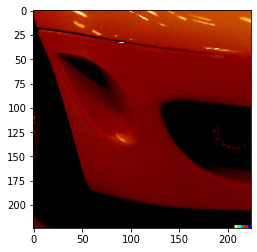

In [45]:
import random as rd
import matplotlib.pyplot as plt
id = rd.randrange(0,62)

print("ID :", id)
print(f'다음 그림은 {y_test[id]} 입니다.')
print(f'모델의 예측 : {y_pred[id]}')

if y_test[id] == y_pred[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
    
plt.imshow(x_test_s[id].reshape(224, 224, 3))
plt.show()

In [96]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [97]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
39

ID : 39
다음 그림은 1 입니다.
모델의 예측 : 0
틀렸어요


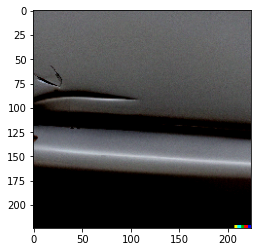

In [49]:
true_false = (y_test == y_pred)
f_id = np.where(true_false == False)[0]
f_n = len(f_id)

id = f_id[rd.randrange(0,f_n)]
print("ID :", id)
print(f'다음 그림은 {y_test[id]} 입니다.')
print(f'모델의 예측 : {y_pred[id]}')

if y_test[id] == y_pred[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
    
plt.imshow(x_test_s[id].reshape(224, 224, 3))
plt.show()

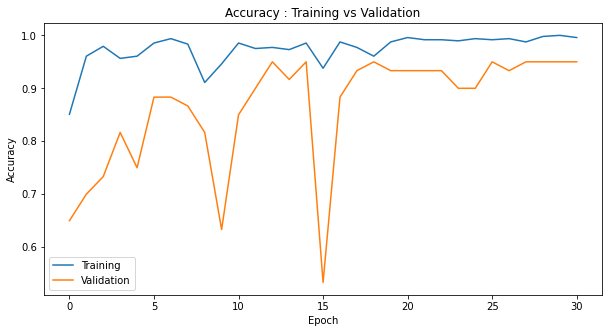

In [98]:
import matplotlib.pyplot as plt
if not isinstance(history, dict) :
    history = history.history

plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

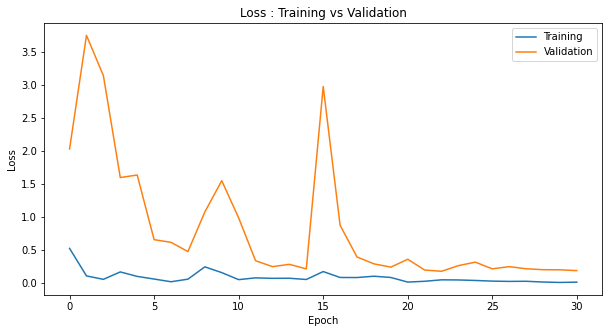

In [99]:
if not isinstance(history, dict) :
    history = history.history

plt.figure(figsize=(10, 5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

## 4.모델링 II
* **세부요구사항**
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Data Augmentation을 통해 데이터를 증가 시킵니다.
            - ImageDataGenerator를 사용합니다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.
            - VGG16(이미지넷)을 사용해 봅시다.

### (1) Data Augmentation
- **세부요구사항**
    * 모델 학습에 이용할 이미지 데이터를 증강시키세요.
    * Keras의 ImageDataGenerator를 이용
        - [ImageDataGenerator document](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

    * image generator를 이용하여 학습
        * 모델 구조는 이미 생성한 1,2,3 중 하나를 선택하여 학습


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [50]:
img_size = 224 ## 사이즈 조정 가능

train_path = dataset_path + 'Car_Images_train/'
valid_path = dataset_path + 'Car_Images_valid/'

#### 1) ImageGenerator 생성
* ImageDataGenerator 함수 사용
    * 주요 옵션
        * rotation_range: 무작위 회전을 적용할 각도 범위
        * zoom_range: 무작위 줌을 적용할 범위 [1-zoom_range, 1+zoom_range]
        * horizontal_flip: 무작위 좌우반전을 적용할지 여부
        * vertical_flip: 무작위 상하반전을 적용할지 여부
        * rescale: 텐서의 모든 값을 rescale 값으로 나누어줌 (이 경우에는 255로 나누어서 0~1사이의 값으로 변경)

#### 2) 경로로 부터 이미지 불러 올 준비
* .flow_from_directory 이용
    * 디렉토리에서 이미지를 가져와서 데이터 증강을 적용하고 batch 단위로 제공하는 generator를 생성합니다.
    * 이미지를 불러올 때 target_size로 크기를 맞추고, 
    * class_mode로 이진 분류(binary)를 수행하도록 지정합니다.


In [ ]:
train_generator = 

valid_generator = 


#### 3) 학습
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 train_generator 이용. 
    - validation_data = valid_generator 지정
    - Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

* 구조 설계

In [74]:
x_train_s = x_train.copy()
x_test_s = x_test.copy()
x_valid_s = x_valid.copy()

from tensorflow.keras.applications.inception_v3 import preprocess_input

# 이미지 데이터 스케일링
x_train_s = preprocess_input(x_train_s)
x_test_s = preprocess_input(x_test_s)
x_valid_s = preprocess_input(x_valid_s)

In [75]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

keras.backend.clear_session()
base_model = MobileNet(weights = 'imagenet',
             include_top=False,
            input_shape = (224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs = base_model.input, outputs = predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

* 학습
    * EarlyStopping 설정하기
    * 학습 데이터에 train_generator, validation_data=valid_generator 사용

In [76]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss',
                                 patience = 4,
                                 verbose = 1,
                                 factor = 0.2,
                                 min_lr = 0.0001)

es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 8,
                   verbose = 1, 
                   restore_best_weights = True)

In [77]:
train_datagen = ImageDataGenerator(
    # featurewise_center=False,  # set input mean to 0 over the dataset
    # samplewise_center=False,  # set each sample mean to 0
    # featurewise_std_normalization=False,  # divide inputs by std of the dataset
    # samplewise_std_normalization=False,  # divide each input by its std
    # zca_whitening=False,  # apply ZCA whitening
    rotation_range=180, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.3, # Randomly zoom image 
    width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

train_datagen.fit(x_train_s)

valid_datagen = ImageDataGenerator(
    # featurewise_center=False,  # set input mean to 0 over the dataset
    # samplewise_center=False,  # set each sample mean to 0
    # featurewise_std_normalization=False,  # divide inputs by std of the dataset
    # samplewise_std_normalization=False,  # divide each input by its std
    # zca_whitening=False,  # apply ZCA whitening
    rotation_range=180, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.3, # Randomly zoom image 
    width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

valid_datagen.fit(x_valid_s)

In [78]:
hist = model.fit(train_datagen.flow(x_train_s, y_train),
                 epochs = 1000, validation_data=valid_datagen.flow(x_valid_s, y_valid),
                 verbose = 1, callbacks = [es, lr_reduction] )

Epoch 1/1000
16/16 [==============================] - 18s 382ms/step - loss: 0.6360 - accuracy: 0.8137 - val_loss: 0.2783 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 2/1000
16/16 [==============================] - 5s 328ms/step - loss: 0.2511 - accuracy: 0.8965 - val_loss: 3.5423 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 3/1000
16/16 [==============================] - 6s 343ms/step - loss: 0.2917 - accuracy: 0.8944 - val_loss: 0.6202 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 4/1000
16/16 [==============================] - 5s 333ms/step - loss: 0.1505 - accuracy: 0.9441 - val_loss: 0.5403 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 5/1000
16/16 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9317
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
16/16 [==============================] - 6s 341ms/step - loss: 0.1726 - accuracy: 0.9317 - val_loss: 0.5288 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 6/1000
16/16 [==============================] - 

#### 4) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [79]:
from sklearn.metrics import classification_report
y_pred = model.predict(x_test_s)
y_pred = np.ravel(np.round(y_pred)).astype(int)
print(classification_report(y_test, y_pred))

performance_test = model.evaluate(x_test_s, y_test, batch_size = 16)
print(f'Test Loss : {performance_test[0]:.6f} |  Test Accuracy : {performance_test[1]*100:.2f}%')

2/2 [==============================] - 0s 42ms/step
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        31
           1       0.91      1.00      0.95        31

    accuracy                           0.95        62
   macro avg       0.96      0.95      0.95        62
weighted avg       0.96      0.95      0.95        62

4/4 [==============================] - 0s 29ms/step - loss: 0.0989 - accuracy: 0.9516
Test Loss : 0.098942 |  Test Accuracy : 95.16%


In [73]:
from sklearn.metrics import classification_report
y_pred = model.predict(x_test_s)
y_pred = np.ravel(np.round(y_pred)).astype(int)
print(classification_report(y_test, y_pred))

performance_test = model.evaluate(x_test_s, y_test, batch_size = 16)
print(f'Test Loss : {performance_test[0]:.6f} |  Test Accuracy : {performance_test[1]*100:.2f}%')

2/2 [==============================] - 0s 44ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        31
           1       0.94      1.00      0.97        31

    accuracy                           0.97        62
   macro avg       0.97      0.97      0.97        62
weighted avg       0.97      0.97      0.97        62

4/4 [==============================] - 0s 27ms/step - loss: 0.0647 - accuracy: 0.9677
Test Loss : 0.064658 |  Test Accuracy : 96.77%


### (2) Transfer Learning
- **세부요구사항**
    * VGG16 모델은 1000개의 클래스를 분류하는 데 사용된 ImageNet 데이터셋을 기반으로 사전 학습된 가중치를 가지고 있습니다. 
        * 따라서 이 모델은 이미지 분류 문제에 대한 높은 성능을 보입니다.
        * 이 모델은 보통 전이학습(transfer learning)에서 기본적으로 사용되며, 특히 대규모 데이터셋이 없을 때는 기본 모델로 사용되어 fine-tuning을 수행합니다.
    * VGG16 함수로 부터 base_model 저장


In [ ]:
from tensorflow.keras.applications import VGG16

#### 1) VGG16 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 True로 설정하여 모델의 모든 레이어들이 fine-tuning에 대해 업데이트되도록 합니다.


In [ ]:
base_model = VGG16(                 )




#### 2) VGG16과 연결한 구조 설계
* VGG16을 불러와서 Flatten, Dense 등으로 레이어 연결하기

#### 3) 학습
- **세부요구사항**
    - 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
    - 데이터
        * Image Generator를 연결하거나
        * 기존 train, validation 셋을 이용해도 됩니다.
        - Early Stopping을 반드시 사용하세요.
        - 최적의 가중치를 모델에 적용하세요.

#### 4) 성능 평가